# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.927970,False,-1.981533
1,-1.083805,False,-3.723497
2,-0.226177,False,0.983810
3,1.038523,True,7.076553
4,-1.945568,False,-5.117323
...,...,...,...
995,-1.346369,False,-1.004089
996,-0.438968,True,3.642206
997,-0.962828,False,-2.929469
998,-1.660566,False,-4.741123


<Axes: xlabel='v0'>

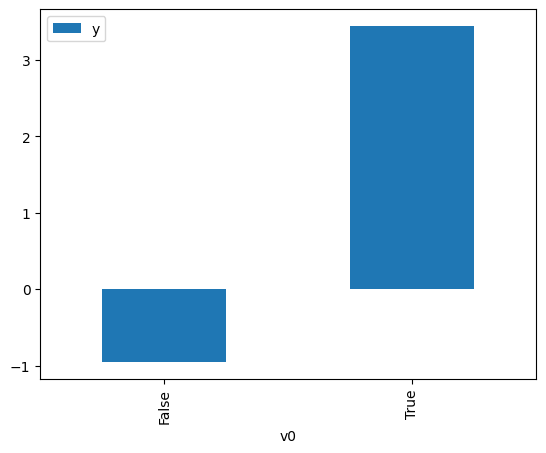

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

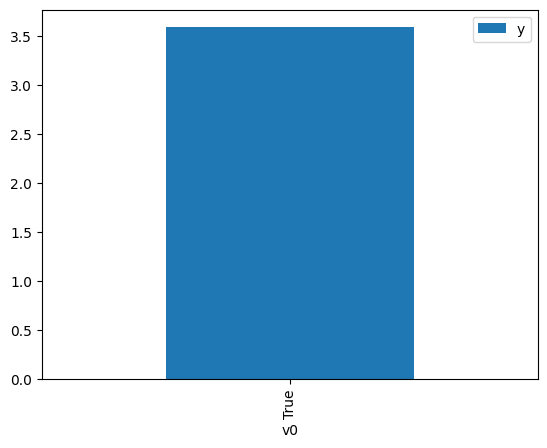

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.226177,False,0.983810,0.650005,1.538450
1,0.082350,False,0.182770,0.494963,2.020355
2,-0.782027,False,-1.034342,0.854543,1.170217
3,-1.968994,False,-2.943354,0.985654,1.014554
4,0.217843,False,-1.240142,0.425346,2.351029
...,...,...,...,...,...
995,0.396353,False,1.361466,0.338338,2.955622
996,-2.057610,False,-4.961019,0.988032,1.012113
997,0.345265,False,2.084554,0.362423,2.759207
998,-2.057610,False,-4.961019,0.988032,1.012113


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.142079,True,0.686635,0.390591,2.560220
1,-0.171506,True,3.121739,0.376180,2.658301
2,-1.260370,True,2.494531,0.059428,16.827097
3,-0.330021,True,4.878428,0.302756,3.302991
4,-0.696994,True,5.055119,0.168750,5.925917
...,...,...,...,...,...
995,-1.232187,True,0.593536,0.062777,15.929400
996,-1.783693,True,-0.364626,0.020919,47.803326
997,-1.595285,True,1.809523,0.030602,32.677502
998,-2.464946,True,0.046094,0.005182,192.979413


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                              9589.
Date:                Mon, 26 Jun 2023   Prob (F-statistic):                        0.00
Time:                        17:22:54   Log-Likelihood:                         -1415.5
No. Observations:                1000   AIC:                                      2835.
Df Residuals:                     998   BIC:                                      2845.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.3339      0.030     77.454      0.000       2.275       2.393
x2             5.0531      0.054     93.257      0.000       4.947       5.159
==============================================================================
Omnibus:                        1.212   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.545   Jarque-Bera (JB):                1.087
Skew:                           0.039   Prob(JB):                        0.581
Kurtosis:                       3.142   Cond. No.                         1.90
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""